In [ ]:
import numpy as np
from MCTS import MCTS
from beam_search import beam_search_neural, beam_search_with_heuristic
from models.supervised_networks import PolicyNet, ValueNet, load_networks
import torch
import Former.daily_board as db
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from models.PPO_classes import load_ppo_models
np.random.seed(22)
random.seed(22)

# LOAD ALL NETS
nets = load_networks()
# Value
value_net_w32d5   = nets['v_w32d5']
value_net_w32d10  = nets['v_w32d10']
value_net_w64d5   = nets['v_w64d5']
value_net_w64d10  = nets['v_w64d10']
# Policy
policy_net_w32d5  = nets['pi_w32d5']
policy_net_w32d10 = nets['pi_w32d10']
policy_net_w64d5  = nets['pi_w64d5']
policy_net_w64d10 = nets['pi_w64d10']

# LOAD PPO MODELS
ppos = load_ppo_models()
actor_large = ppos['actor_large']
actor_small = ppos['actor_small']
critic_large = ppos['critic_large']
critic_small = ppos['critic_small']

print("Loaded all models successfully.")

Loaded all models successfully.


# 6.4: Search techniques with heuristics

Here is the code used to generate results with MCTS and beam search.

## 6.4.1: Random boards


In [2]:
np.random.seed(22)
boards = np.random.randint(0,4,(1000,9,7))

### 1) Monte Carlo Tree Search

The code given here is used to search with MCTS on random boards with PPO (small model).

To change model, change policy_type:
- 'network': uses a neural network. Network must be a policy network, and input as net2 - all networks are loaded (see top)
- 'heuristic': use t=1 for 1-look-ahead and t=2 for 2-look-ahead
- 'ppo': Must be actors, input into net2 - all networks are loaded (see top)

In [6]:
np.random.seed(22)
random.seed(22)

mcts_params = {"num_simulations": 1000,     # num_simulations does not make a difference since we use a time limit
               "c_puct": 10,                # Exploration constant
               "min_exploration_limit": 10, # Minimum exploration from first node
               "N": 9,                      # Board dimensions (NxM with S shapes)  
               "M": 7,
               "S": 4,
               "rollout": True,             # We always use rollout - we implemented the choice not to, and use value functions, but this did not work well
               "Q_type": "avg",             # We tried max and avg, but avg works better
               "use_prior": True}           # We always use prior in the PUCT calculation, but use_prior=False gives uniform prior

all_times_per_board =  []
all_moves_per_board =  []

n = 0
for board in boards:
    if n == 0:
        pass
    mcts = MCTS(board, None, actor_small, mcts_params, True, policy_type = 'ppo')
    solution_lengths, times, actions, n_sims = mcts.search_with_time_limit(time_limit=10)
    del mcts
    all_times_per_board.append(times)
    all_moves_per_board.append(solution_lengths)
    
    if (n+1) % 50 == 0:
        print(f"Boards completed: {n+1}")
    n += 1

Boards completed: 50
Boards completed: 100
Boards completed: 150
Boards completed: 200
Boards completed: 250
Boards completed: 300
Boards completed: 350
Boards completed: 400
Boards completed: 450
Boards completed: 500
Boards completed: 550
Boards completed: 600
Boards completed: 650
Boards completed: 700
Boards completed: 750
Boards completed: 800
Boards completed: 850
Boards completed: 900
Boards completed: 950
Boards completed: 1000


In [7]:
rows = []
for board_idx, (times, moves) in enumerate(zip(all_times_per_board, all_moves_per_board)):
    for t, m in zip(times, moves):
        rows.append({
            "method": 'ppo_w32d5',
            "board": board_idx,
            "time": t,
            "moves": m
        })

df = pd.DataFrame(rows)
df.to_csv("random_mcts_ppo325.csv", index=False)

### 2) Beam search

In [3]:
beam_widths = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

moves_beam_ppo = np.zeros((len(boards), len(beam_widths)))
times_beam_ppo = np.zeros((len(boards), len(beam_widths)))

methods = [
    #("w32d5",  moves_beam_w32d5,  times_beam_w32d5),
    #("w32d10", moves_beam_w32d10, times_beam_w32d10),
    #("w64d5",  moves_beam_w64d5,  times_beam_w64d5),
    #("w64d10", moves_beam_w64d10, times_beam_w64d10),
    #("ppo_w64d10", moves_beam_ppo, times_beam_ppo),
    ("ppo_w32d5", moves_beam_ppo, times_beam_ppo)
]

output_file = "random_beam_ppo325.csv"
first_write = True

i = 0
for board in boards:
    # Iterate over beam widths
    for j, bw in enumerate(beam_widths):
        t0 = time.time()
        _, move_sequence = beam_search_neural(board, critic_small, bw, value_type='ppo')
        t1 = time.time()

        elapsed = t1 - t0
        moves_beam_ppo[i, j] = len(move_sequence)
        times_beam_ppo[i, j] = elapsed

        if elapsed > 5: # End if the last took more than 5 seconds - the next always take longer than 10
            break

    if (i+1) % 50 == 0:
        print(f"Boards completed: {i+1}")

    # Write data to CSV
    records = []
    for method_name, moves_arr, times_arr in methods:
        for j, bw in enumerate(beam_widths):
            t = times_arr[i, j]
            if t == 0:
                continue
            records.append({
                "method":     method_name,
                "board":      i,
                "time":       float(t),
                "moves":      int(moves_arr[i, j]),
                "beam_width": bw,
                })

    df_i = pd.DataFrame.from_records(
        records,
        columns=["method","board","time","moves","beam_width"]
    )
    df_i.to_csv(
        output_file,
        mode='w' if first_write else 'a',
        header=first_write,
        index=False
    )
    i += 1
    first_write = False

Boards completed: 50
Boards completed: 100
Boards completed: 150
Boards completed: 200
Boards completed: 250
Boards completed: 300
Boards completed: 350
Boards completed: 400
Boards completed: 450
Boards completed: 500
Boards completed: 550
Boards completed: 600
Boards completed: 650
Boards completed: 700
Boards completed: 750
Boards completed: 800
Boards completed: 850
Boards completed: 900
Boards completed: 950
Boards completed: 1000


### Plot our results

/Users/espen/Desktop/masteroppgave_uten_chat/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


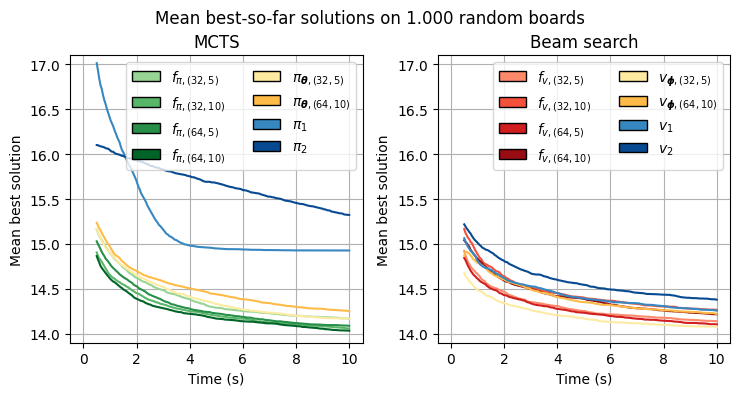

In [8]:
from figure_functions import plot_search_results_random_boards
plot_search_results_random_boards(show=True)

In [182]:
# Table
import pandas as pd
import numpy as np

df_mcts = pd.read_csv("results/6.4_search/mcts/mcts_random.csv")     # columns: method, board, time, moves
df_beam = pd.read_csv("results/6.4_search/beam/beam_random.csv")     # columns: method, board, time, moves, beam_width

df_mcts_10 = df_mcts[df_mcts["time"] <= 10]
df_beam_10 = df_beam[df_beam["time"] <= 10]

# 3) For each board and method, take the best (minimum) moves
best_mcts = df_mcts_10.groupby(["method", "board"], as_index=False)["moves"].min()
best_beam = df_beam_10.groupby(["method", "board"], as_index=False)["moves"].min()

# 4) Compute mean and std for each method
summary_mcts = best_mcts.groupby("method")["moves"].agg(["mean", "std"])
summary_beam = best_beam.groupby("method")["moves"].agg(["mean", "std"])

# 5) Combine summaries
summary = pd.concat([summary_mcts, summary_beam])
summary.index.name = "Method"
summary = summary.rename(columns={"mean": "Mean moves", "std": "Std dev"})

print(summary)
# 6) Display to user
#ace_tools.display_dataframe_to_user("Mean and Std.dev of best solutions at t=10s", summary)
#latex_table = summary.to_latex(float_format="%.2f", caption="Mean and standard deviation of moves at $t=10\\,$s", label="tab:solver_std")
#print("\nLaTeX format:\n")
#print(latex_table)


            Mean moves   Std dev
Method                          
1lookahead      14.927  1.564007
2lookahead      15.323  1.790496
ppo_w32d5       14.170  1.452312
ppo_w64d10      14.252  1.495571
w32d10          14.058  1.420794
w32d5           14.168  1.464897
w64d10          14.034  1.423682
w64d5           14.088  1.435380
1lookahead      14.258  1.530287
2lookahead      14.379  1.606219
ppo_w32d5       14.078  1.479901
ppo_w64d10      14.222  1.555357
w32d10          14.266  1.617362
w32d5           14.139  1.556310
w64d10          14.217  1.591365
w64d5           14.104  1.537383


## 6.4.2: Daily boards

In [183]:
# Optimal solution analysis
board_tuples = db.get_daily_board()
best_sols = [bt[1] for _, bt in board_tuples.items()]
print(f"Mean best solution: {np.mean(best_sols)}")
print(f"Standard deviation: {np.std(best_sols)}")

Mean best solution: 13.58
Standard deviation: 1.3429817571359635


### Monte Carlo Tree Search

To change model, change policy_type:
- 'network': uses a neural network. Network must be input as net2 - all networks are loaded (see top)
- 'heuristic': use t=1 for 1-look-ahead and t=2 for 2-look-ahead
- 'ppo': use t=1 for (32,5) model and t=2 for (64,10) model

In [4]:
# Mean solution by time
np.random.seed(22)
random.seed(22)
board_tuples = db.get_daily_board()
mcts_params = {"num_simulations": 1000,
               "c_puct": 10,
               "min_exploration_limit": 10,
               "N": 9,
               "M": 7,
               "S": 4,
               "rollout": True,
               "Q_type": "avg",
               "use_prior": True}

all_times_per_board_ppo = []
all_moves_per_board_ppo = []

n = 0
for key, board_tuple in board_tuples.items():
    board = board_tuple[0]
    
    mcts = MCTS(board, None, actor_small, mcts_params, True, best_sol = board_tuple[1], policy_type='ppo')
    solution_lengths, times, actions, n_sims = mcts.search_with_time_limit(60)
    del mcts
    all_times_per_board_ppo.append(times)
    all_moves_per_board_ppo.append(solution_lengths)
    
    if (n+1) % 1 == 0:
        print(f"Boards completed: {n+1}")
    n += 1

Boards completed: 1
Boards completed: 2
Boards completed: 3
Boards completed: 4
Boards completed: 5
Boards completed: 6
Boards completed: 7
Boards completed: 8
Boards completed: 9
Boards completed: 10
Boards completed: 11
Boards completed: 12
Boards completed: 13
Boards completed: 14
Boards completed: 15
Boards completed: 16
Boards completed: 17
Boards completed: 18
Boards completed: 19
Boards completed: 20
Boards completed: 21
Boards completed: 22
Boards completed: 23
Boards completed: 24
Boards completed: 25
Boards completed: 26
Boards completed: 27
Boards completed: 28
Boards completed: 29
Boards completed: 30
Boards completed: 31
Boards completed: 32
Boards completed: 33
Boards completed: 34
Boards completed: 35
Boards completed: 36
Boards completed: 37
Boards completed: 38
Boards completed: 39
Boards completed: 40
Boards completed: 41
Boards completed: 42
Boards completed: 43
Boards completed: 44
Boards completed: 45
Boards completed: 46
Boards completed: 47
Boards completed: 48
B

In [5]:
rows = []
for board_idx, (times, moves) in enumerate(zip(all_times_per_board_ppo, all_moves_per_board_ppo)):
    for t, m in zip(times, moves):
        rows.append({
            "method": 'ppo_w32d5',
            "board": board_idx,
            "time": t,
            "moves": m
        })

df = pd.DataFrame(rows)
df.to_csv("daily_mcts_ppo325.csv", index=False)

### Beam search

In [7]:
beam_widths = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]
moves_beam_ppo = np.zeros((100, len(beam_widths)))
times_beam_ppo = np.zeros((100, len(beam_widths)))

# This is your “variants” catalogue used for saving:
variants = [
    #("w32d5",  moves_beam_w32d5,  times_beam_w32d5),
    #("w32d10", moves_beam_w32d10, times_beam_w32d10),
    #("w64d5",  moves_beam_w64d5,  times_beam_w64d5),
    #("w64d10", moves_beam_w64d10, times_beam_w64d10),
    #("ppo_w64d10", moves_beam_ppo, times_beam_ppo),
    ("ppo_w32d5", moves_beam_ppo, times_beam_ppo)
]

output_file = "daily_beam_ppo325.csv"
first_write = True

# fetch the dict once up‐front
daily = db.get_daily_board()   # { board_id: (board, best_len, _), … }
first_write = True

for i, (board_id, board_tuple) in enumerate(daily.items()):
    board, best_len, _ = board_tuple

    # —– run beam‐search up to best found —–
    for j, bw in enumerate(beam_widths):
        t0 = time.time()
        _, move_sequence = beam_search_neural(board, critic_small, bw, value_type='ppo')
        t1 = time.time()

        elapsed = t1 - t0
        moves_beam_ppo[i, j] = len(move_sequence)
        times_beam_ppo[i, j] = elapsed

        # if we found the true optimum, fill the rest and stop
        if len(move_sequence) == best_len:
            for k in range(j+1, len(beam_widths)):
                moves_beam_ppo[i, k] = best_len
                times_beam_ppo[i, k] = 2 * elapsed
            break

        if elapsed > 60:
            break

    print(f"Board {board_id} done in {time.time() - t0:.2f}s "
          f"(best at beam {beam_widths[j]})")

    # —– build & append CSV rows —–
    records = []
    for method_name, moves_arr, times_arr in variants:
        for j, bw in enumerate(beam_widths):
            t = times_arr[i, j]
            if t == 0:
                continue
            records.append({
                "method":     method_name,
                "board":      i,
                "time":       float(t),
                "moves":      int(moves_arr[i, j]),
                "beam_width": bw,
                })

    df_i = pd.DataFrame.from_records(
        records,
        columns=["method","board","time","moves","beam_width"]
    )
    df_i.to_csv(
        output_file,
        mode='w' if first_write else 'a',
        header=first_write,
        index=False
    )
    first_write = False

Board feb03 done in 0.09s (best at beam 1)
Board jan27 done in 3.16s (best at beam 64)
Board feb04 done in 12.85s (best at beam 256)
Board feb05 done in 0.55s (best at beam 8)
Board feb06 done in 0.08s (best at beam 1)
Board feb07 done in 0.09s (best at beam 1)
Board feb08 done in 8.23s (best at beam 128)
Board feb09 done in 0.10s (best at beam 1)
Board feb10 done in 28.04s (best at beam 512)
Board feb11 done in 0.07s (best at beam 1)
Board feb12 done in 112.06s (best at beam 1024)
Board feb13 done in 13.51s (best at beam 256)
Board feb14 done in 22.83s (best at beam 256)
Board feb15 done in 65.84s (best at beam 512)
Board feb17 done in 61.76s (best at beam 512)
Board feb18 done in 0.93s (best at beam 16)
Board feb19 done in 18.92s (best at beam 256)
Board feb20 done in 0.21s (best at beam 2)
Board feb22 done in 59.91s (best at beam 1024)
Board feb23 done in 60.03s (best at beam 512)
Board feb24 done in 3.16s (best at beam 32)
Board feb25 done in 0.11s (best at beam 1)
Board feb26 done

Plot our solutions

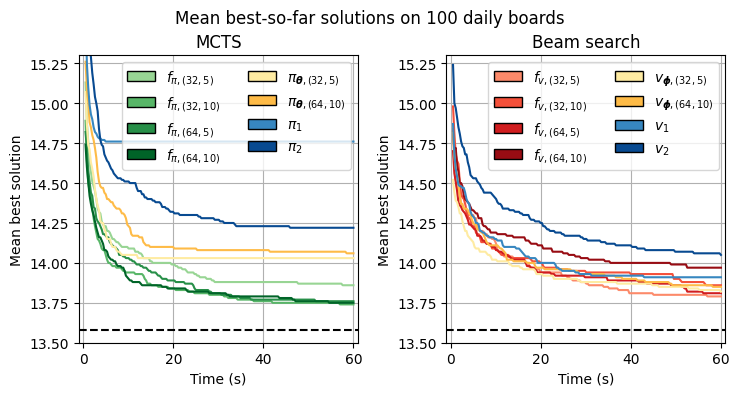

In [9]:
from figure_functions import plot_search_results_daily_boards
plot_search_results_daily_boards(show=True)

Plot aggregate results over models - code for this is in the plotting function.

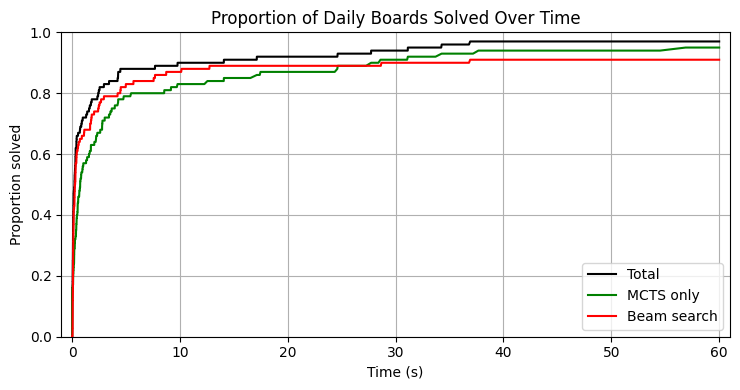


Proportion of daily boards solved at specific time checkpoints:
  After  1 second(s): Total: 0.720,  MCTS: 0.560,  Beam: 0.660
  After 10 second(s): Total: 0.900,  MCTS: 0.830,  Beam: 0.870
  After 30 second(s): Total: 0.940,  MCTS: 0.910,  Beam: 0.900
  After 60 second(s): Total: 0.970,  MCTS: 0.950,  Beam: 0.910


In [10]:
from figure_functions import plot_search_correct_proportion
plot_search_correct_proportion(show=True)

### Analyze optimal solutions for two boards

Boards chosen: 
- March 6th (10 moves)
- March 13th (16 moves)

In [28]:
print(np.where(np.array(actual_best_sols)==16))

(array([32, 34, 37, 57, 61, 64, 72, 74, 87, 91, 99]),)


In [171]:
solutions = []
solution_lengths = []
board_tuple = db.get_daily_board("may18")
#board_tuple = db.get_daily_board("may16")

mcts_params = {"num_simulations": 1000,
               "c_puct": 10,
               "min_exploration_limit": 10,
               "N": 9,
               "M": 7,
               "S": 4,
               "rollout": True,
               "Q_type": "avg",
               "use_prior": True}

for i in range(1000):
    np.random.seed()
    random.seed()

    
    mcts = MCTS(board_tuple[0], None, policy_net_w64d10, mcts_params, True, best_sol = board_tuple[1], policy_type='network')
    sl, times, actions, n_sims = mcts.search_with_time_limit(60)
    solution_lengths.append(sl[-1])
    solutions.append(actions)
    
    del mcts
    
    if (i+1) % 10 == 0:
        print(f"Boards completed: {i+1}")

Boards completed: 10
Boards completed: 20
Boards completed: 30
Boards completed: 40


KeyboardInterrupt: 

In [135]:
print(max(solution_lengths))

11


(array([[1, 2, 3, 1, 0, 1, 2],
       [1, 0, 2, 3, 0, 0, 3],
       [2, 2, 0, 1, 0, 2, 2],
       [1, 2, 3, 1, 3, 3, 1],
       [3, 1, 1, 0, 2, 0, 2],
       [1, 2, 1, 1, 1, 3, 0],
       [0, 1, 2, 2, 2, 1, 1],
       [2, 0, 0, 3, 0, 0, 1],
       [3, 1, 2, 0, 1, 2, 2]]), 16, None)


In [ ]:
c = []
for s in solutions:
    if s[0] not in c:
        c.append(s[0])

print(board_tuple[0])
print(len(c))
print(c)

In [146]:
import pickle

results = {"solution_lengths": solution_lengths,
           "solutions": solutions}

with open("mcts_may18_results.pkl", "wb") as f:
    pickle.dump(results, f)


(array([[2, 2, 3, 1, 0, 1, 3],
       [3, 3, 3, 2, 0, 0, 0],
       [3, 0, 1, 1, 3, 2, 1],
       [2, 3, 1, 2, 3, 2, 1],
       [0, 1, 1, 2, 3, 2, 1],
       [0, 1, 3, 3, 1, 1, 0],
       [0, 1, 1, 1, 1, 3, 0],
       [0, 0, 0, 0, 0, 2, 0],
       [3, 1, 1, 1, 3, 3, 3]]), 11, None)


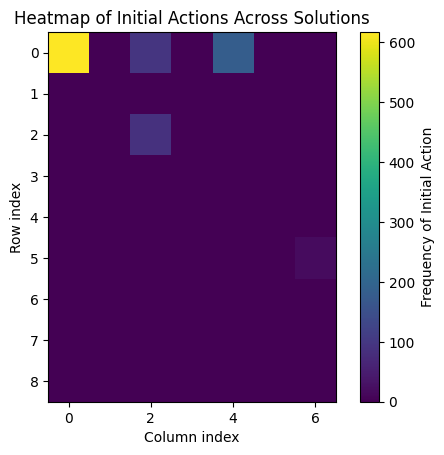

In [152]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load solutions from pickle
with open("mcts_may18_results.pkl", "rb") as f:
    data = pickle.load(f)
solutions = data["solutions"]  # list of lists of (row, col)
#
#print(db.get_daily_board("may19"))
print(db.get_daily_board("may18"))

# Extract first moves
first_moves = [sol[0] for sol in solutions]

# Build frequency heatmap over 9x7 grid
heatmap = np.zeros((9, 7), dtype=int)
for r, c in first_moves:
    heatmap[r, c] += 1

# Plot heatmap
plt.figure()
plt.imshow(heatmap, origin='upper')
plt.colorbar(label='Frequency of Initial Action')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.title('Heatmap of Initial Actions Across Solutions')
plt.show()

Distinct optimal actions at each step: [17, 8, 8, 7, 7, 5, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]
Most popular path: [(4, 5), (2, 2), (5, 6), (7, 6), (6, 2), (4, 2), (8, 0), (4, 5), (4, 6), (6, 0), (6, 4), (5, 3), (6, 0), (6, 1), (6, 0), (7, 3)]


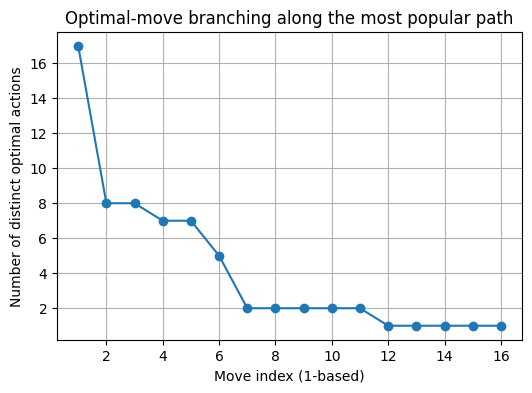

In [166]:
from collections import Counter
import matplotlib.pyplot as plt

# Assume `solutions` is your list of optimal solutions for one board,
# each solution is a list of actions [(r0,c0), (r1,c1), …] of length K.

K = len(solutions[0])
current_sols = solutions.copy()

counts = []
popular_path = []

for t in range(K):
    # 1) Collect the t-th action across remaining solutions
    actions_t = [sol[t] for sol in current_sols]
    # 2) Count distinct optimal actions at this step
    distinct_actions = set(actions_t)
    counts.append(len(distinct_actions))
    # 3) Find the most popular action
    pop_action, freq = Counter(actions_t).most_common(1)[0]
    popular_path.append(pop_action)
    # 4) Filter solutions to those that follow pop_action at step t
    current_sols = [sol for sol in current_sols if sol[t] == pop_action]

# Print results
print("Distinct optimal actions at each step:", counts)
print("Most popular path:", popular_path)

# Plot the branching factor along the popular path
plt.figure(figsize=(6, 4))
plt.plot(range(1, K+1), counts, marker='o')
plt.xlabel("Move index (1-based)")
plt.ylabel("Number of distinct optimal actions")
plt.title("Optimal-move branching along the most popular path")
plt.grid(True)
plt.show()


In [258]:
from collections import Counter
import numpy as np
from Cpp_code.former_class_cpp import FormerGame

def optimal_branching_along_popular_path(initial_board,
                                         true_optimal_length,
                                         mcts_params,
                                         policy_net,
                                         N=1000):
    """
    Returns a list `branching` of length K, where
    branching[t] = # distinct optimal first-moves from the state at depth t
    along the single “most popular” trajectory.
    """

    board = initial_board.copy()
    K = true_optimal_length
    branching = []
    groups = []
    solution_path = []
    for depth in range(K):
        # 1) Run MCTS N times, collecting first-action of each run that
        #    actually reached optimal length K-depth
        groups.append(len(FormerGame.get_valid_turns_static(board)))
        first_moves = []
        for _ in range(N):
            mcts = MCTS(board, None, policy_net_w64d10, mcts_params, True, best_sol = K-depth, policy_type='network')
            
            sol_lens, times, actions, _ = mcts.search_with_time_limit(60)
            mcts = None  # free memory
            if sol_lens[-1] == (K - depth):
                first_moves.append(actions[0])
            if (_+1)%100 == 0:
                print(f"Depth: {depth}. Boards: {_+1}.")
        if len(first_moves)==0:
            # no runs found an optimal path? record 0 and break
            branching.append(0)
            break

        # 2) Count distinct optimal first moves
        cnt = Counter(first_moves)
        distinct = len(cnt)
        branching.append(distinct)

        # 3) Pick the most popular move and step forward
        pop_move, _ = cnt.most_common(1)[0]
        solution_path.append(pop_move)
        board = np.array(FormerGame.apply_turn_static(board, pop_move))
        print(f"Finished depth {depth}")

    return branching, groups, solution_path

# --- Usage Example ---

# 1) Load your “hard” board and its best-known length K
board, best_len, _ = db.get_daily_board("may20")  # returns (board_array, K)
print(best_len)
mcts_params = {"num_simulations": 1000,
               "c_puct": 10,
               "min_exploration_limit": 10,
               "N": 9,
               "M": 7,
               "S": 4,
               "rollout": True,
               "Q_type": "avg",
               "use_prior": True}

# 3) Compute the branching factors
branching, groups, solution_path = optimal_branching_along_popular_path(board,
                                                 true_optimal_length=best_len,
                                                 mcts_params=mcts_params,
                                                 policy_net=policy_net_w64d10,
                                                 N=100)


13
Depth: 0. Boards: 200.
Finished depth 0
Finished depth 1
Finished depth 2
Finished depth 3
Finished depth 4
Finished depth 5
Finished depth 6
Finished depth 7
Finished depth 8
Finished depth 9
Finished depth 10
Finished depth 11
Finished depth 12


In [257]:
import pickle

# 1) Bundle into a dict
#results = {
#    "branching":     branching,
#    "groups":        groups,
#    "solution_path": solution_path
#}

# 2) Save it
#with open("branching_may19.pkl", "wb") as f:
#    pickle.dump(results, f)

# …later, or in a fresh session…

# 3) Load it back
with open("branching_may19.pkl", "rb") as f:
    loaded = pickle.load(f)

# 4) Unpack
branching_loaded     = loaded["branching"]
groups_loaded        = loaded["groups"]
solution_path_loaded = loaded["solution_path"]

print(solution_path_loaded)


[(4, 5), (2, 2), (2, 0), (4, 3), (2, 0), (5, 6), (7, 6), (4, 5), (4, 4), (6, 2), (6, 4), (4, 2), (8, 0), (6, 0), (6, 1), (6, 0)]


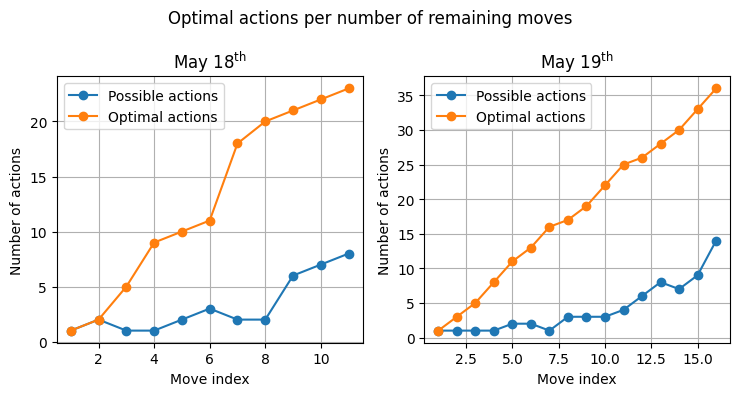

array([16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [227]:
with open("branching_may18.pkl", "rb") as f:
    loaded = pickle.load(f)

branching_may18     = loaded["branching"]
groups_may18        = loaded["groups"]
solution_path_may18 = loaded["solution_path"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.5,4))
ax1.plot(range(len(branching_may18), 0, -1), branching_may18, marker='o')
ax1.plot(range(len(branching_may18), 0, -1), groups_may18, marker='o')
ax1.set_xlabel("Move index")
ax1.set_ylabel("Number of actions")
ax1.set_title(r"May 18$^\mathrm{th}$")
ax1.legend(["Possible actions", "Optimal actions"])
ax1.grid(True)

with open("branching_may19.pkl", "rb") as f:
    loaded = pickle.load(f)

branching_may19     = loaded["branching"]
groups_may19        = loaded["groups"]
solution_path_may19 = loaded["solution_path"]

ax2.plot(np.arange(len(branching_may19), 0, -1), branching_may19, marker='o')
ax2.plot(np.arange(len(branching_may19), 0, -1), groups_may19, marker='o')
ax2.set_xlabel("Move index")
ax2.set_ylabel("Number of actions")
ax2.set_title(r"May 19$^\mathrm{th}$")
ax2.legend(["Possible actions", "Optimal actions"])
ax2.grid(True)

fig.suptitle(r"Optimal actions per number of remaining moves")
plt.tight_layout()
plt.show()

np.arange(len(branching_may19), 0, -1)

[8, 7, 6, 2, 2, 3, 2, 1, 1, 2, 1]
[14, 9, 7, 8, 6, 4, 3, 3, 3, 1, 2, 2, 1, 1, 1, 1]


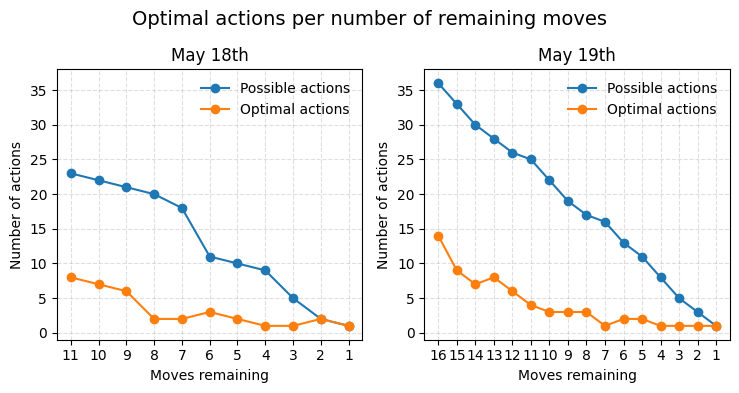

In [256]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

with open("branching_may18.pkl", "rb") as f:
    data18 = pickle.load(f)

with open("branching_may19.pkl", "rb") as f:
    data19 = pickle.load(f)

# bundle everything so we can loop
runs = [
    ("May 18th", data18["branching"], data18["groups"]),
    ("May 19th", data19["branching"], data19["groups"]),
]

fig, axes = plt.subplots(1, 2, figsize=(7.5,4), sharey=False)

for ax, (title, branching, groups) in zip(axes, runs):
    n_moves = len(branching)
    moves_remaining = np.arange(n_moves, 0, -1)
    
    print(branching)

    ax.plot(moves_remaining, groups,    linestyle='-',  marker='o', label='Possible actions')
    ax.plot(moves_remaining, branching, linestyle='-',   marker='o', label='Optimal actions')
    
    ax.set_title(title)
    ax.set_xlabel("Moves remaining")  
    ax.set_xticks(moves_remaining)

    ax.set_ylabel("Number of actions")      
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(frameon=False)
    ax.invert_xaxis()
    ax.set_ylim(-1, 38)

# global y-label & super-title
#axes[0].set_ylabel("Number of actions")
fig.suptitle("Optimal actions per number of remaining moves", y=0.97, fontsize=14)
fig.tight_layout()
